In [1]:
import numpy as np
import scipy.special as special
from scipy import integrate
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

### rBergomi model
"Bayer, C., Friz, P.K. and Gatheral, J., Pricing under rough volatility. Quant. Finance, 2016 16(6), 887-904."


\begin{equation}
Z_t = \eta\sqrt{2\alpha + 1}\int\limits_{0}^t(t − s)^\alpha dW_s,
\end{equation}
for $\alpha\in\left(-\frac{1}{2},0\right]$ and $\eta>0$. $Z_t$ is used for simuation of the volatility $v_t$.

$S_t$ is the stock process and $X_t:=\log(X_t/X_0)$

\begin{equation}
v_t = v_0\exp\left(Z_t-\frac{\eta^2}{2}t^{2\alpha+1}\right)\\
X_t = -\frac{1}{2}\int\limits_{0}^tv_s ds + \int\limits_{0}^t\sqrt{v_s}dB_s
\end{equation}

and finally $B_t=\rho W_t+\sqrt{1-\rho^2}\tilde W_t$ where $W_t$ and $\tilde W_t$ are two independent Browinian motion, and $\rho\in[-1,1]$ is the correlation between the two BM.


In [2]:
def simulate_fBM(W,H,TTM):
    """
    simulate fBM
    
    @W: normal random variable (#paths x #times)
    @H: Hurst Index
    @TTM: time horizon
    """
    
    assert 0<H<1.0
    N = W.shape[1]
    M = W.shape[0]
    
    ## Step1: create partition 
    
    X=np.linspace(0, 1, num=N)
    
    # get rid of starting point
    X=X[1:N]
    
    ## Step 2: compute covariance matrix
    Sigma=np.zeros((N-1,N-1))
    for j in range(N-1):
        for i in range(N-1):
            if i==j:
                Sigma[i,j]=np.power(X[i],2*H)/2/H
            else:
                s=np.minimum(X[i],X[j])
                t=np.maximum(X[i],X[j])
                Sigma[i,j]=np.power(t-s,H-0.5)/(H+0.5)*np.power(s,0.5+H)*special.hyp2f1(0.5-H, 0.5+H, 1.5+H, -s/(t-s))
        
    ## Step 3: compute Cholesky decomposition
    
    P=np.linalg.cholesky(Sigma)
    
    ## Step 4: draw Gaussian rv
    
    W = W
    
    ## Step 5: get V
    
    G=np.zeros((M,N))
    for i in range(M):
        G[i,1:N]=np.dot(P,W[i,1:])
        
    #Use self-similarity to extend to [0,T] 
    
    return G*np.power(TTM,H)


def rBergomi(eta,alpha,rho,v0,TTM,N,M):
    """
    Simulation of the rBergomi model:
    "Bayer, C., Friz, P.K. and Gatheral, J., Pricing under rough volatility. Quant. Finance, 2016 16(6), 887-904."
    
    @eta: fBM parameter
    @alpha: fBM rought parameter
    @TTM: time horizon
    @N: # points in the simulation grid
    @M: # paths to simulate
    """
    
    assert -0.5<alpha and alpha<=0.0, "alpha is "+ str(alpha)
    times = T*np.linspace(0, 1, num=N)
    H = alpha+0.5
    W = np.random.normal(loc=0.0, scale=1.0, size=[M,N])
    tW = np.random.normal(loc=0.0, scale=1.0, size=[M,N])
    B = rho*W+np.sqrt(1-rho**2)*tW
    Z = eta*np.sqrt(2*alpha+1)*simulate_fBM(W,H,TTM)
    v = v0*np.exp(Z-eta**2/2*times**(2*alpha+1))
    
    dB = np.diff(B)
    X=np.zeros((M,N))
    for i in range(1,N):
        X[:,i] = X[:,i-1]+np.sqrt(v[:,i-1])*(B[:,i]-B[:,i-1]) 
    X[:,1:N] = X[:,1:N]-0.5*integrate.cumtrapz(v, times)
    
    return X,v,times

In [3]:
T=1
N=200
M=5000

H = 0.5
alpha = H-0.5
v0 = (0.07)**2
rho = -0.1
eta = 1
S0 = 1

Xt,vt,times=rBergomi(eta,alpha,rho,v0,T,N,M)
St = S0*np.cumprod(np.exp(Xt),axis=1)

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


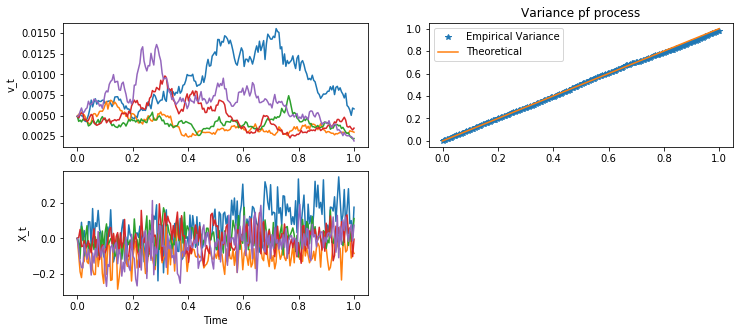

In [4]:
plt.subplots(figsize=(12, 5))
for i in range(5):
    plt.subplot(2,2,1)
    plt.plot(times,vt[i,:])
    plt.ylabel('v_t')
    plt.subplot(2,2,3)
    plt.plot(times,Xt[i,:])

Z = (np.log(vt/v0)+eta**2/2*times**(2*alpha+1))/(eta*np.sqrt(2*alpha+1))
plt.xlabel('Time')
plt.ylabel('X_t')
plt.subplot(2,2,2)
plt.title('Variance pf process')
plt.plot(times,np.var(Z,axis=0),'*',label="Empirical Variance")
plt.plot(times,np.power(times,2*H)/2/H,label="Theoretical")
plt.legend()
plt.show()

## ML Stuff

In [23]:
def fBm_path_rDonsker(grid_points, M, H, T, kernel="optimal"):
    """
    @grid_points: # points in the simulation grid
    @H: Hurst Index
    @T: time horizon
    @M: # paths to simulate
    @kernel: kernel evaluation point use "optimal" for momen-match or "naive" for left-point
    """
    
    assert 0<H<1.0
    
    ## Step1: create partition 
    dt=1./(grid_points-1)
    X=np.linspace(0, 1, num=grid_points)
    
    # get rid of starting point
    X=X[1:grid_points]
    
    ## Step 2: Draw random variables
    
    dW = np.power(dt, H) *np.random.normal(loc=0, scale=1, size=[M, grid_points-1])
        
    ## Step 3: compute the kernel evaluation points
    i=np.arange(grid_points-1) + 1
    # By default use optimal moment-matching
    if kernel=="optimal":
        opt_k=np.power((np.power(i,2*H)-np.power(i-1.,2*H))/2.0/H,0.5)
    # Alternatively use left-point evaluation
    elif kernel=="naive" : 
        opt_k=np.power(i,H-0.5)
    else:
        raise NameError("That was not a valid kernel")
    
    
    ## Step 4: Compute the convolution
    
    Y = np.zeros([M, n])
    for i in range(int(M)):
        Y[i, 1:n] = np.convolve(opt_k, dW[i, :])[0:n - 1]
        
    #Use self-similarity to extend to [0,T] 
    
    return Y*np.power(T,H)

In [24]:
H1 = np.array([0.1,0.2,0.3,0.4,0.5])
H2 = np.random.uniform(0,0.5,5)
H3 = np.random.beta(1,9,5)

In [25]:
HH = H3#np.concatenate([H1,H2,H3])
HH = [0.02, 0.07, 0.06, 0.13, 0.22]

In [26]:
Y = []
T=1
n=100
M=5000
X = np.empty((M*len(HH),n+1))
eta = 1

times=np.linspace(0,T,n)
for i,H in tqdm(enumerate(HH)):
    a = H -0.5
    x = eta*np.sqrt(2*a+1)*fBm_path_rDonsker(n, M, H, T,kernel="naive")-eta**2/2*times**(2*a+1)
    X[i*M:(i+1)*M,:-1] = x
    X[i*M:(i+1)*M,-1] = H
X = X[:,:,np.newaxis]
np.random.shuffle(X)
X.shape

(25000, 101, 1)

In [27]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tf.__version__

from datetime import datetime

logdir = "./logs/" + "mse_loss_1e4"+datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
BATCH_SIZE = 64
BUFFER_SIZE = 1

In [29]:
train_size = int(14000)
test_size  = int(7500)
val_size = int(3500)

x_train = X[:train_size,:-1,:]
y_train = X[:train_size,-1,:]

x_val = X[train_size:train_size+val_size,:-1,:]
y_val = X[train_size:train_size+val_size,-1,:]


In [30]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(14000, 100, 1)
(14000, 1)
(3500, 100, 1)
(3500, 1)


In [31]:
activation = lambda x: tf.nn.leaky_relu(x, alpha=0.1, name="LeakyReLU")

do_rate = 0

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv1D(32, 20, input_shape=(n,1), activation='linear', padding="same"))
model.add(tf.keras.layers.LeakyReLU(0.1))
model.add(tf.keras.layers.MaxPooling1D((3),padding="same"))
model.add(tf.keras.layers.Dropout(rate=do_rate))

model.add(tf.keras.layers.Conv1D(64, 20, activation='linear', padding="same"))
model.add(tf.keras.layers.LeakyReLU(0.3))
model.add(tf.keras.layers.MaxPooling1D((3), padding="same"))
model.add(tf.keras.layers.Dropout(rate=do_rate))

model.add(tf.keras.layers.Conv1D(128, 20, activation='linear', padding="same"))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1)) 
model.add(tf.keras.layers.MaxPooling1D((3), padding="same"))
model.add(tf.keras.layers.Dropout(rate=do_rate))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='linear'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))           
model.add(tf.keras.layers.Dropout(rate=do_rate))

model.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model.add(tf.keras.layers.Dropout(rate=do_rate))


model.summary()

optimizer = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.mean_squared_error)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 100, 32)           672       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 100, 32)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 34, 32)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 34, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 34, 64)            41024     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 34, 64)            0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 12, 64)           

In [32]:
x = tf.random.normal([BATCH_SIZE,n,1])

y = model(x)

y.shape

TensorShape([64, 1])

In [33]:
EPOCHS = 50
training_history = model.fit(x_train,y_train, 
                             batch_size = BATCH_SIZE,
                             epochs=EPOCHS,
                             validation_data=(x_val,y_val),
                             callbacks=[tensorboard_callback])

initial_epoch = EPOCHS

Train on 14000 samples, validate on 3500 samples
Epoch 1/50
14000/14000 [==============================] - 11s 794us/sample - loss: 0.0159 - val_loss: 0.0069
Epoch 2/50
14000/14000 [==============================] - 10s 725us/sample - loss: 0.0060 - val_loss: 0.0051
Epoch 3/50
14000/14000 [==============================] - 11s 789us/sample - loss: 0.0045 - val_loss: 0.0039
Epoch 4/50
14000/14000 [==============================] - 9s 676us/sample - loss: 0.0037 - val_loss: 0.0034
Epoch 5/50
14000/14000 [==============================] - 9s 616us/sample - loss: 0.0034 - val_loss: 0.0033
Epoch 6/50
14000/14000 [==============================] - 8s 559us/sample - loss: 0.0032 - val_loss: 0.0031
Epoch 7/50
14000/14000 [==============================] - 8s 590us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 8/50
14000/14000 [==============================] - 9s 629us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 9/50
14000/14000 [==============================] - 8s 585us/sample - loss: 0.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0.05450843737374346


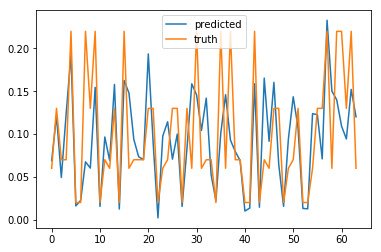

In [34]:
x,y = x_val[:BATCH_SIZE,:,:],y_val[:BATCH_SIZE,:]
plt.plot(model(x))
plt.plot(y)
plt.legend(['predicted','truth'])
print(np.sqrt(np.mean((model(x_val).numpy()-y_val)**2)))

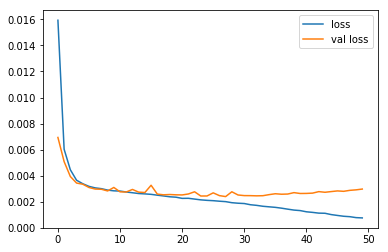

In [35]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.legend(['loss','val loss'])